In [1]:
# import pandas as pd
# import numpy as np
# from matplotlib import pyplot as plt
# import seaborn as sns
# import matplotlib as mpl
# from matplotlib.pyplot import show
# from scipy.stats import chi2_contingency
%matplotlib inline

import io
from nbformat import current

def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("sp_analysis_script.ipynb")

/Users/clarkgao/anaconda/lib/python2.7/site-packages/nbformat/current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


5156 Total sessions
2740 Complete sessions
2602 Valid sessions
2416 Incomplete


(-0.93779550623164942,
 1.0699086146674588,
 -1.084596511745306,
 0.92933724571335274)

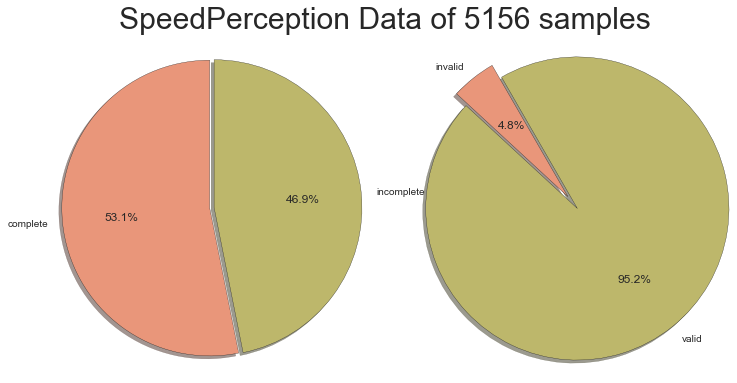

In [2]:
# Summary of the data, numbers of valid/complete/incomplete sessions
# Valid sessions are those who accurately labeld at least 4 out of 5 honeypot pairs

num_total_sessions = 5156
num_comlete_sessions = 2740
num_valid_sessions = 2602
num_incomplete_sessions = 2416

print '%d Total sessions'%num_total_sessions
print '%d Complete sessions'%num_comlete_sessions
print '%d Valid sessions'%num_valid_sessions
print '%d Incomplete'%num_incomplete_sessions

# Pie Chart to show the above numbers
cmap = plt.cm.prism
fig = plt.figure(figsize=(12,6))
fig.suptitle("SpeedPerception Data of %d samples"%(num_total_sessions), fontsize=30)
ax1 = fig.add_subplot(121)
ax1.pie(
    [num_comlete_sessions, num_incomplete_sessions],
    labels=['complete', 'incomplete'],
    colors=['darksalmon', 'darkkhaki'],
    startangle=90,
    shadow=True,
    explode=(0, 0.03),
    autopct='%1.1f%%'
)
ax1.axis('equal')
ax2 = fig.add_subplot(122)
ax2.pie(
    [num_comlete_sessions-num_valid_sessions, num_comlete_sessions],
    labels=['invalid', 'valid'],
    colors=['darksalmon', 'darkkhaki'],
    startangle=120,
    shadow=True,
    explode=(0, 0.1),
    autopct='%1.1f%%'
)
ax2.axis('equal')

In [3]:
# Read valid session result data
df_valid = pd.read_csv('./data/sp_csv3.csv')
print 'There are %d valid votes'%(len(df_valid))
print 'There are %d valid sessions'%(len(df_valid)/16.)
df_valid.head(3)

There are 41632 valid votes
There are 2602 valid sessions


,sessionID,pairID,TimeToClick_InMS,userAgent,vote
0,58aPyrqJm6zGYK6eJ,5786da3020cfb49feadbbe6c,5643.0,Mozilla/5.0 (iPhone; CPU iPhone OS 9_3_2 like ...,left
1,58aPyrqJm6zGYK6eJ,5786da3020cfb49feadbbe6d,4561.0,Mozilla/5.0 (iPhone; CPU iPhone OS 9_3_2 like ...,right
2,58aPyrqJm6zGYK6eJ,5786da2f20cfb49feadbbe5a,5484.0,Mozilla/5.0 (iPhone; CPU iPhone OS 9_3_2 like ...,equal


 [],

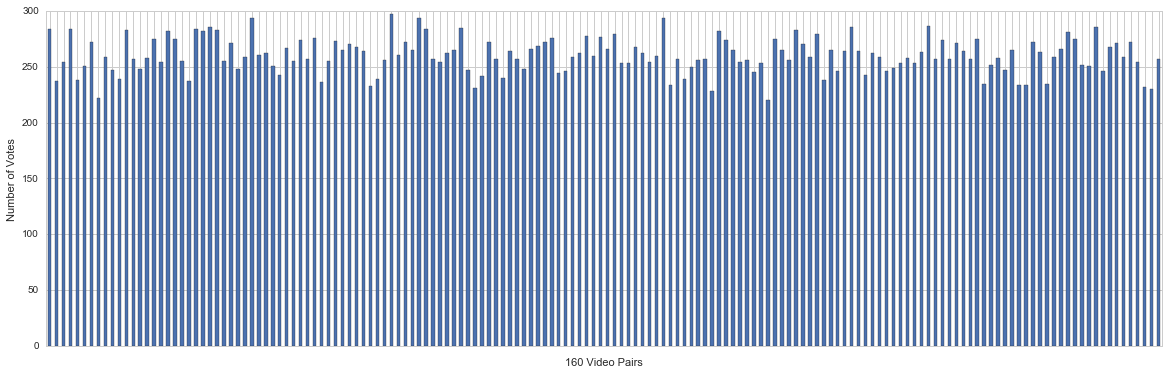

In [4]:
# Number of valid votes on each video pair
pair_count = df_valid.groupby(['pairID']).agg(['count'])
plt.figure(figsize=(20,6))
s = pd.Series(pair_count['vote']['count'].values)
g = s.plot(kind='bar' )
g.set(xticklabels=[], xlabel='160 Video Pairs', ylabel='Number of Votes')

In [5]:
# Compute majority vote for each pair
max_vote = {}
for i, id_ in enumerate(df_valid['pairID'].unique()):
    one_pair = df_valid.loc[df_valid['pairID']==id_]
    tmp = one_pair.groupby(['vote']).count()['sessionID']
    if len(tmp) < 3:
        for v in ['equal', 'left', 'right']:
            if not v in tmp.index.values:
                tmp.loc[v] = 0        
    count0, count1, count2 = tmp[0], tmp[1], tmp[2]
    new_l = sorted([(count1, 'pick1'), (count2, 'pick2'), (count0, 'pick0')], key=lambda x: x[0])
    max_vote[id_] = int(new_l[2][1][-1])
max_pick = []
for _id in df_valid['pairID'].ravel():
    max_pick.append(max_vote[_id])
df_valid['majority_pick'] = max_pick  
df_valid.head(3)

,sessionID,pairID,TimeToClick_InMS,userAgent,vote,majority_pick
0,58aPyrqJm6zGYK6eJ,5786da3020cfb49feadbbe6c,5643.0,Mozilla/5.0 (iPhone; CPU iPhone OS 9_3_2 like ...,left,1
1,58aPyrqJm6zGYK6eJ,5786da3020cfb49feadbbe6d,4561.0,Mozilla/5.0 (iPhone; CPU iPhone OS 9_3_2 like ...,right,2
2,58aPyrqJm6zGYK6eJ,5786da2f20cfb49feadbbe5a,5484.0,Mozilla/5.0 (iPhone; CPU iPhone OS 9_3_2 like ...,equal,2


In [6]:
df_perf = pd.read_csv('./data/sp_csv1.csv')
df_perf = df_perf[[
        '_TTFB',
        '_firstPaint',
        '_domContentLoadedEventStart',
        '_domContentLoadedEventEnd',
        '_render',
        '_SpeedIndex',
        '_loadTime',
        '_lastVisualChange',
        '_visualComplete',
        'uid']]
df_pair = pd.read_csv('./data/sp_csv2.csv')
mapping = {'equal': 0, 'left': 1, 'right': 2}
df_valid = df_valid.replace({'vote': mapping})

In [7]:
# merge performance metrics with user sessions
# map performance metrics to picks

for col in df_perf.columns.tolist()[:-1]:
    d = ([],[])
    for i in range(len(df_pair)):
        wpt1, wpt2 = df_pair['uid_left'][i], df_pair['uid_right'][i]
        d[0].append(df_perf[df_perf['uid']==wpt1][col].values[0])
        d[1].append(df_perf[df_perf['uid']==wpt2][col].values[0])
    df_pair[col[1:] + "_%d"%(1)] = d[0]
    df_pair[col[1:] + "_%d"%(2)] = d[1]
pair_perf = pd.merge(df_valid, df_pair, on=['pairID'])

d_diff = {}
pair_perf_m = pair_perf.iloc[:,range(8,26)]

for col in df_perf.columns.tolist()[:-1]:
    l1 = pair_perf_m[col[1:] + '_1'].ravel()
    l2 = pair_perf_m[col[1:] + '_2'].ravel()
    pick = pick_one(l1, l2)
    d_diff[col[1:] + "_pick"] = pick

perf_pick = pd.DataFrame(d_diff)
df_valid_perf = pd.concat([pair_perf[['pairID', 'vote', 'majority_pick']],perf_pick], axis=1)
df_pair.head(3)

,pairID,uid_left,uid_right,TTFB_1,TTFB_2,firstPaint_1,firstPaint_2,domContentLoadedEventStart_1,domContentLoadedEventStart_2,domContentLoadedEventEnd_1,...,render_1,render_2,SpeedIndex_1,SpeedIndex_2,loadTime_1,loadTime_2,lastVisualChange_1,lastVisualChange_2,visualComplete_1,visualComplete_2
0,5786da3020cfb49feadbbe6c,160605_JY_2PB,160605_X9_2DH,178,1338,1478,2782,1968,3252,2085,...,1696,2896,3419,4704,3924,7011,8396,7996,8400,8000
1,5786da3020cfb49feadbbe6d,160605_X9_2DH,160605_1W_2ZH,1338,280,2782,2191,3252,2325,3542,...,2896,2296,4704,3661,7011,3392,7996,13308,8000,8400
2,5786da2f20cfb49feadbbe5a,160605_TF_2MS,160605_HA_2PK,97,611,1976,1622,2212,1687,2533,...,2096,1296,3048,3178,3625,5026,8095,7996,8100,8000


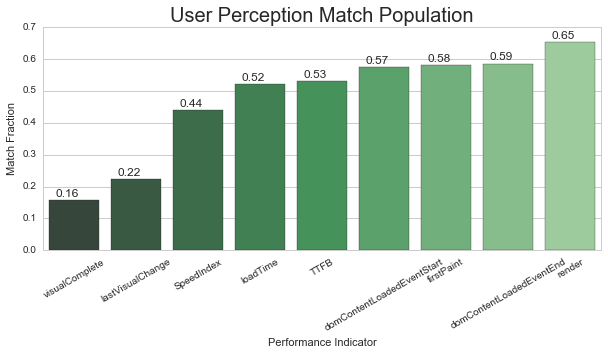

In [8]:
# Percentage match of each performance based pick to population pick
target1 = 'Population'
percentage_match(df_valid_perf, target1)

In [ ]:
# Percentage match of each performance based pick to majority pick
# unique_pair_perf = df_valid_perf.drop_duplicates(['pairID'], keep='first')
# target2 = 'Majrotiy'
# percentage_match(unique_pair_perf, target2)

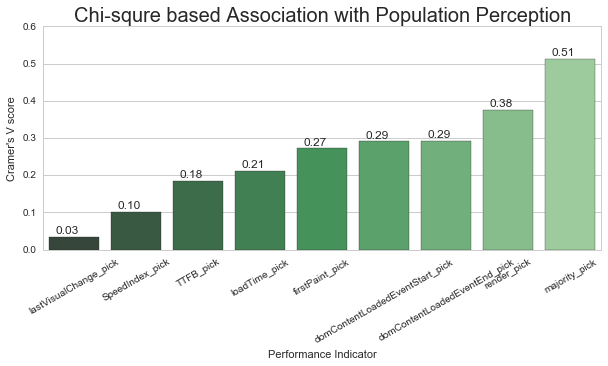

In [9]:
# # cramer's V
# association based on chi-square test statistics 
# WRT to population
d_cat = {}
for col in df_valid_perf.columns.tolist():
    d_cat[col] = map({0: 'euqal', 1: 'left', 2: 'right'}.get, df_valid_perf[col])
chiSquare_association(d_cat, target1)

In [ ]:
# WRT to majority
# chiSquare_association(d_cat, target2)

In [10]:
import scipy.stats as scp

d_pair_entropy = {}
d_colMetric_delta = {}

col_m = df_perf.columns.tolist()[:-1] 
pearson_corr = []
spearman_corr = []

for c in col_m:
    dd = {}
    for i, id_ in enumerate(pair_perf['pairID'].unique()):
        tmp = pair_perf.loc[pair_perf['pairID'] == id_]
        result_list = tmp['vote'].tolist()
        ent = entropy(result_list)
        d_pair_entropy[id_] = ent
        c1 = c[1:]+'_1'
        c2 = c[1:]+'_2'
        v1 = tmp[c1].unique()[0]
        v2 = tmp[c2].unique()[0]
        delta = (v1 - v2)/((v1+v2)/2.)
        dd[id_] = abs(delta)
        d_colMetric_delta[c] = dd
    a1 = pd.Series(d_pair_entropy)
    a2 = pd.Series(d_colMetric_delta[c])
    pearson_corr.append((c, scp.pearsonr(a1, a2)[0]))
    spearman_corr.append((c, scp.spearmanr(a1, a2)[0]))
    
df_corr= pd.DataFrame({'Metric':[x[0][1:] for x in spearman_corr]*2, 
              'Corr':[x[1] for x in pearson_corr]+[x[1] for x in spearman_corr],
              'Method':['Pearson']*(len(col_m))+['Spearman']*(len(col_m))
             })
df_corr = df_corr.sort(['Corr'], ascending=True)
df_corr = df_corr.fillna(df_corr.median())

/Users/clarkgao/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:33: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


 [],

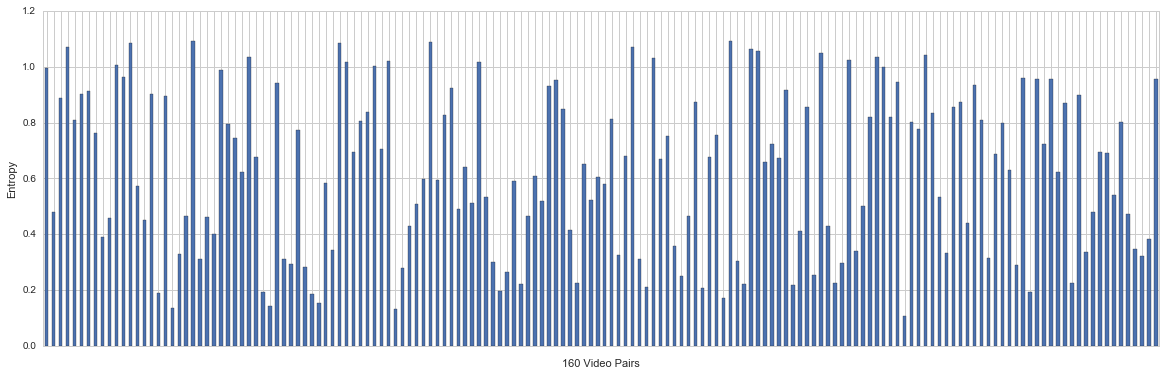

In [11]:
plt.figure(figsize=(20,6))
s = pd.Series(d_pair_entropy.values())
g = s.plot(kind='bar' )
# plt.xticks(rotation=40)
g.set(xticklabels=[], xlabel='%d Video Pairs'%160, ylabel='Entropy')

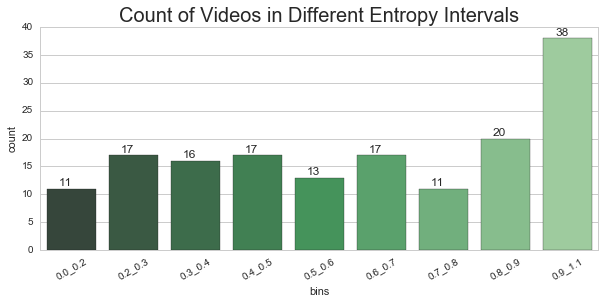

In [12]:
bins = [0, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1]
d_entropy_count = {}
for i in range(len(bins) - 1):
    d_entropy_count['%.1f_%.1f'%(bins[i], bins[i+1])] = 0
c_list = []
for v in d_pair_entropy.values():
    for i in range(len(bins) - 1):
        if bins[i] <= v < bins[i+1]:
            d_entropy_count['%.1f_%.1f'%(bins[i], bins[i+1])] += 1
for key, value in d_entropy_count.items():
    c_list.append((key, value))
c_list = sorted(c_list, key=lambda x: x[0])
plot_bar(c_list, 'Count of Videos in Different Entropy Intervals', 'count','bins')

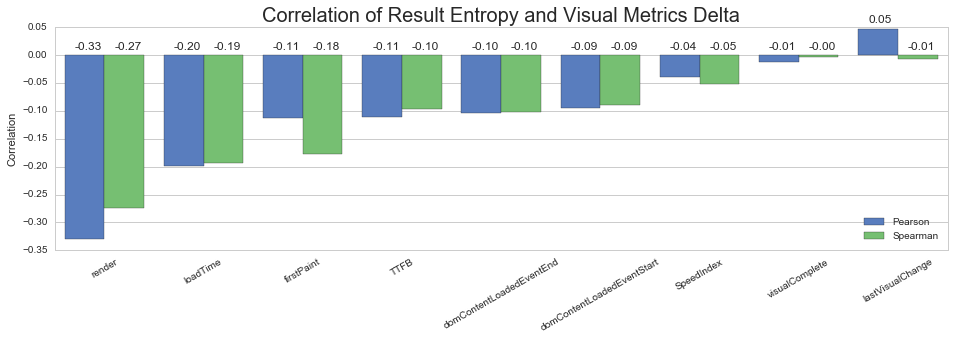

In [13]:
plt.figure(figsize=(16,4))
plt.title('Correlation of Result Entropy and Visual Metrics Delta', size=20)
plt.gca()
ax = sns.barplot(x="Metric", y="Corr", hue="Method", data=df_corr, palette="muted")
for p in ax.patches:
    height = p.get_height()
    if p.get_y() < 0:
        h = 0.01
        ax.text(p.get_x()+0.1, h, '%1.2f'%(p.get_y()))
    else:
        ax.text(p.get_x()+0.1, height+0.01, '%1.2f'%(height))
ax.set(xlabel = '', ylabel='Correlation')
plt.xticks(rotation=30)
plt.legend(loc='lower right')


[('TTFB', 373.0), ('firstPaint', 1651.0), ('render', 1896.0), ('domContentLoadedEventStart', 2461.0), ('domContentLoadedEventEnd', 2645.0), ('SpeedIndex', 4165.0), ('loadTime', 6024.0), ('visualComplete', 9000.0), ('lastVisualChange', 9196.0)]
************** Timing Analysis ****************
Number of tests with view duration less than both TTFB: 13
Number of tests with view duration greater than both TTFB: 41559
Number of tests with duration lying in between both TTFB: 60

Number of tests with view duration less than both firstPaint: 69
Number of tests with view duration greater than both firstPaint: 39861
Number of tests with duration lying in between both firstPaint: 1702

Number of tests with view duration less than both render: 106
Number of tests with view duration greater than both render: 39104
Number of tests with duration lying in between both render: 2422

Number of tests with view duration less than both domContentLoadedEventStart: 922
Number of tests with view duration grea

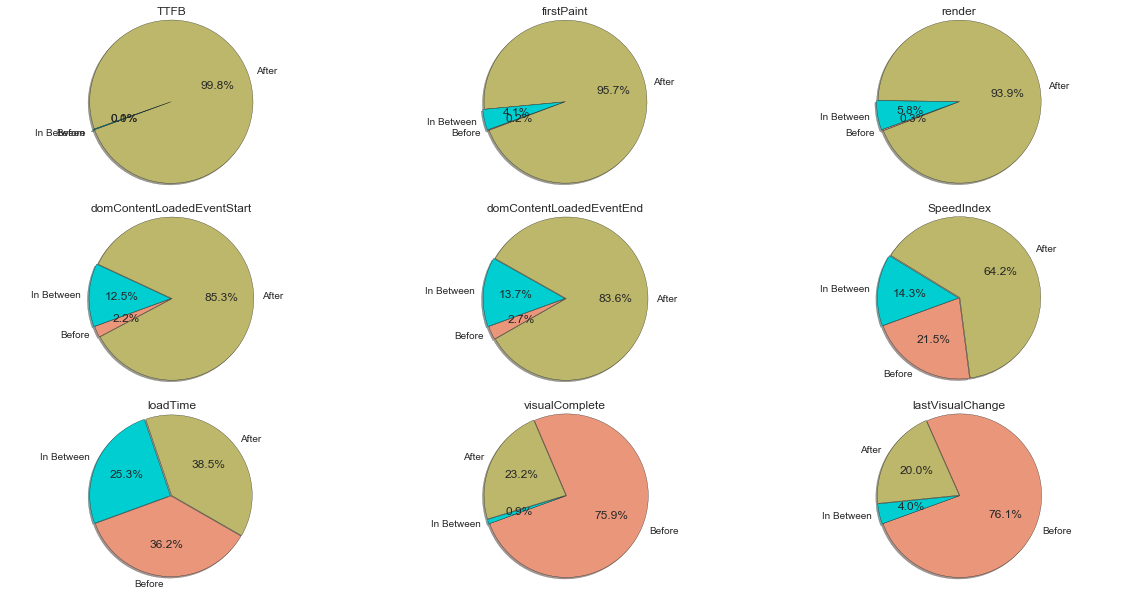

In [14]:
import operator

pair_perf_copy = pair_perf.copy()
GIF_DURATION_STRETCH_FACTOR = 1.09412199387
offset = 800

pair_perf_copy['TimeToClick_InMS'] = GIF_DURATION_STRETCH_FACTOR * pair_perf_copy['TimeToClick_InMS']
visual_metrics_median = {}
for metric in col_m:
    visual_metrics_median[metric[1:]] = df_perf[metric].median()
median_sorted_metrics = sorted(visual_metrics_median.items(), key = operator.itemgetter(1))
print median_sorted_metrics

sorted_visual_metrics = [i[0] for i in median_sorted_metrics]
print '************** Timing Analysis ****************'
### 3.1 : Count of votes made before/after/in-between the visual metrics of a pair
### Pie chart to show the timing numbers
cmap = plt.cm.prism
colors = cmap(np.linspace(0., 1., 2))
fig = plt.figure(figsize=(20, 10))
# fig.suptitle("SpeedPerception Response Timing Data of %d samples"%len(df_timing))
### Charts in the order of sorted visual metrics
chart_count = 0
before_both_metrics = []
after_both_metrics = []
in_between_metrics = []
for metric in sorted_visual_metrics:
    chart_count = chart_count + 1

    d_before_both_metrics = pair_perf_copy.loc[
            (pair_perf_copy['TimeToClick_InMS'] - offset < pair_perf_copy[metric + '_%d'%1])
            & 
            (pair_perf_copy['TimeToClick_InMS'] - offset< pair_perf_copy[metric + '_%d'%2])
        ]

    timings_before_both_metrics = d_before_both_metrics.count()[0]
    print 'Number of tests with view duration less than both %s: %d'%(metric, timings_before_both_metrics)

    d_after_both_metrics = pair_perf_copy.loc[
            (pair_perf_copy['TimeToClick_InMS'] - offset> pair_perf_copy[metric + '_%d'%1])
            & 
            (pair_perf_copy['TimeToClick_InMS'] - offset> pair_perf_copy[metric + '_%d'%2])
        ]
    timings_after_both_metrics = d_after_both_metrics.count()[0]
    print 'Number of tests with view duration greater than both %s: %d'%(metric, timings_after_both_metrics)

    timings_in_between_metrics = (len(pair_perf_copy) - timings_before_both_metrics - timings_after_both_metrics)
    print 'Number of tests with duration lying in between both %s: %d'%(metric, timings_in_between_metrics)
    print 
    
    before_both_metrics.append(timings_before_both_metrics/float(len(pair_perf_copy)))
    after_both_metrics.append(timings_after_both_metrics/float(len(pair_perf_copy)))
    in_between_metrics.append(timings_in_between_metrics/float(len(pair_perf_copy)))
    ax = fig.add_subplot(3,3, chart_count)
    ax.set_title(metric)
    ax.pie(
        [timings_before_both_metrics, timings_after_both_metrics, timings_in_between_metrics],
        labels= ['Before', 'After', 'In Between'],
        colors= ['darksalmon', 'darkkhaki', 'darkturquoise'],
        startangle= 200,
        shadow=True,
        explode=(0, 0.01, 0.01),
        autopct='%1.1f%%',
        labeldistance= 1.1
    )

    ax.axis('equal')

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

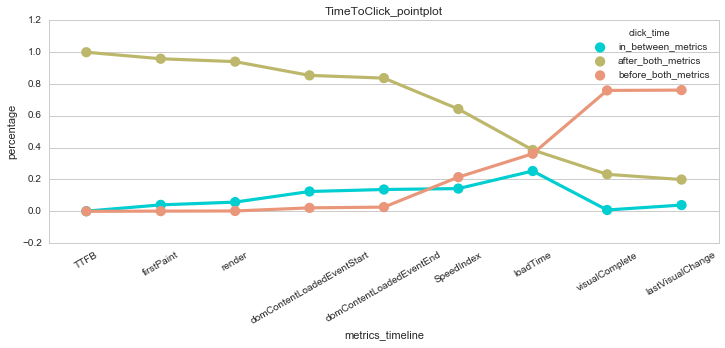

In [15]:
sns.set_context({"figure.figsize": (12, 4)})
total_metrics = [1]*len(sorted_visual_metrics)
ttd_timeline = {
    'percentage': in_between_metrics+after_both_metrics+before_both_metrics,
    'click_time': ['in_between_metrics']*len(sorted_visual_metrics) +
    ['after_both_metrics']*len(sorted_visual_metrics) + ['before_both_metrics']*len(sorted_visual_metrics),
    'metrics_timeline': sorted_visual_metrics * 3
               }
# pd.DataFrame(ttd_timeline).plot(kind='barh', stacked=True)
ttd_df = pd.DataFrame(ttd_timeline)
sns.pointplot(x='metrics_timeline', y='percentage',hue='click_time', data= ttd_df,
             palette={'in_between_metrics':'darkturquoise', 
                     'after_both_metrics':'darkkhaki',
                     'before_both_metrics':'darksalmon'})
plt.ylabel('percentage')
plt.title('TimeToClick_pointplot')
plt.xticks(rotation=30)

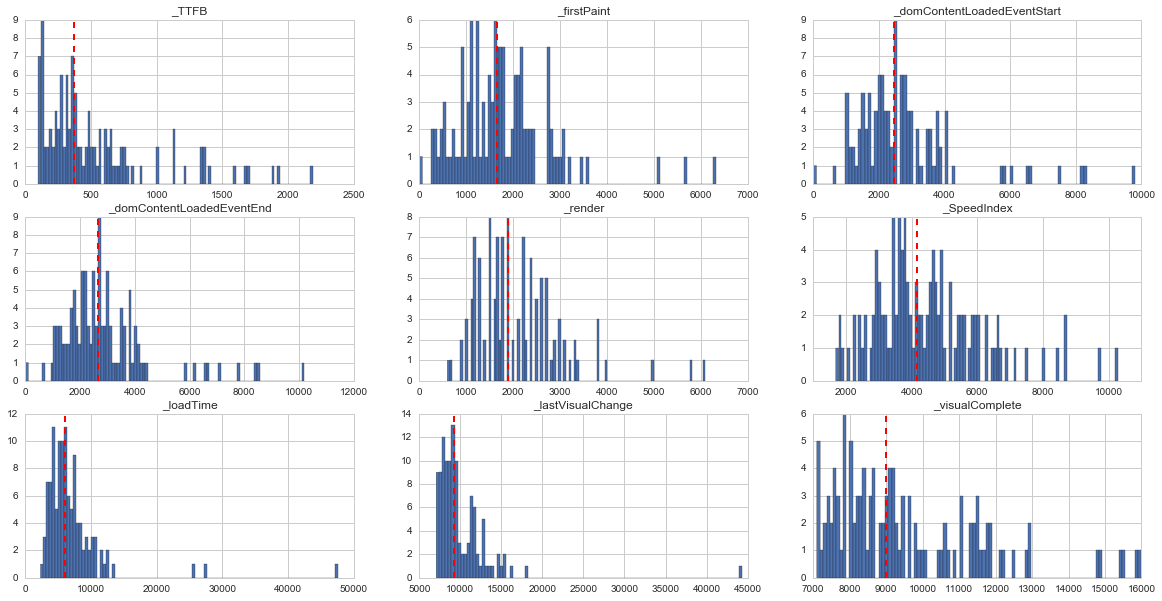

In [16]:
cmap = plt.cm.prism
colors = cmap(np.linspace(0., 1., 2))
fig = plt.figure(figsize=(20, 10))

chart_count = 0
for metric in col_m:
    data = df_perf[metric]
    chart_count = chart_count + 1
    ax = fig.add_subplot(3, 3, chart_count)
    ax.set_title(metric)
    ax.hist(data, bins = 100)
    ax.axvline(data.median(), color = 'red', linestyle = 'dashed', linewidth = 2)